In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SelectFromModel
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

In [2]:
from scipy.stats import t, f

def rss(y_true, y_pred):
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def tss(y):
    return np.sum((y - y.mean()) ** 2)

def multiple_least_squares(X, y):
  
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)
    betas = [model.intercept_, *model.coef_]
    return betas, y_pred

def show_stats(X, y, betas, names, alpha=None):
    n_samples, n_features = X.shape
    deg = n_samples-n_features
    
    if X.shape[1] + 1 == betas.shape[0]:
        X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    
    pred = X.dot(betas).reshape(-1)
    betas = betas.reshape(-1)
    y = y.reshape(-1)
    RSE = ((y-pred)**2).sum()/(n_samples - n_features)

    se2_b = RSE*(np.linalg.inv(np.dot(X.T, X)).diagonal())
    se_b = np.sqrt(se2_b)
    t_stat_b = (betas - 0) / se_b

    p_values = np.array([2*t.sf(np.abs(t_stat), deg) for t_stat in t_stat_b])
    
    df = pd.DataFrame()
    df["Name"] = names
    df["Coefficients"] = betas
    df["Standard Errors"] = se_b
    df["t-stat"] = t_stat_b
    df["p-value"] = p_values
    if alpha:
        rejectH0 = p_values < alpha
        df["reject H0"] = rejectH0    
    
    RSS = np.sum((y - pred)**2)
    MSE = RSS/y.shape[0]
    
    return df

In [3]:
def multiple_least_squares(X, y):
    X = np.concatenate([np.ones([X.shape[0], 1]), X], axis=-1)
    betas = np.dot(np.linalg.inv(np.dot(X.T, X)), X.T).dot(y)
    # Returns the predictions for convenience
    pred = X.dot(betas).reshape(-1)
    return betas, pred

In [4]:
def Ftest(data, y):
    
    X_complete = data.to_numpy()
    y = y.to_numpy()
    n = X_complete.shape[0]
    
    betas_complete, y_pred = multiple_least_squares(X_complete, y)    
    rss_complete = rss(y, y_pred)
    tss_complete = tss(y)
    nf_complete = X_complete.shape[1]

    F_num = (tss_complete - rss_complete) / nf_complete
    F_den = rss_complete / (n - nf_complete - 1)
    F = F_num / F_den

    p_value = f.sf(F, nf_complete, n - nf_complete - 1)
    
    return p_value, F

In [5]:
def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, 
                      subsets_evaluator, subsets_argbest,       
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  
                      subsets_scorer_name=None,     
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    

    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    subsets_test = []
    subsets_metric = []
    subsets_best_features = [] 
    plt.figure()
    candidate_fig = plt.subplot(111) 
    num_evaluations = 0      
    
    selected_features = []  
    all_features = Xtrain_pd.columns
    
   
    model = DummyRegressor() 
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
        
    
    for dim in range(num_features):
        candidate_metrics = [] 
        candidate_models = [] 
        
       
        remaining_features = Xtrain_pd.columns.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]].to_numpy()
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        
        idx_best_candidate = candidates_argbest(candidate_metrics)
        
        selected_features.append(remaining_features[idx_best_candidate])
       
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
       
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
   
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
  
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

In [6]:
def subset_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                     candidates_evaluator, candidates_argbest, 
                     subsets_evaluator, subsets_argbest,       
                     test_evaluator=None, test_argbest=None, 
                     candidates_scorer_name=None,  
                     subsets_scorer_name=None,     
                     verbose=True, weight_step3=0):  
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest

In [7]:
def estimate_sigma(Xtrain_pd, ytrain):
   
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def adj_r2(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))


In [8]:
def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

In [9]:
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
            # if the model is not trained it trains your data
        score = scorer(model, X, y)
        return model, score
    return evaluator    

In [10]:
def calc_vif(X):

    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [11]:
DB = pd.read_csv('forestfires.csv')
DB.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9,8.3,97,4,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


##### I handle the missing values deleting the respective rows

In [12]:
DB = DB.replace('Missing',np.nan, regex=True)
DB.dropna(inplace = True) 

#### Apply the log transformation to the area as suggested by the documentation

In [13]:
DB['log_area'] = np.log(DB['area']+1)

DB = DB.drop(['area'], axis = 1)

#### Here I decided to handle the categorical variables such as 'day' and 'month' changing them into ordinal variables, I also tried the one-hot-encoded but I discarded that option for an interference from the high number of variable in the model which in every case during feature selection ended up giving me as best model the one with some of the month and in most cases no quantitative variables 

In [14]:
DB.day.replace(('mon','tue','wed','thu','fri','sat','sun'),(1,2,3,4,5,6,7), inplace=True)
DB.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace=True)

#### I changed all elements of the dataset in numeric type because I needed that for a function which requires only numeric type object and the month and day variables where identified as cathegorical 

In [15]:
DB = DB.apply(pd.to_numeric, errors='ignore')

#### Plotting all the dataset is a necessary step to know which is the distribution of every variable. In the case of this dataset it's possible to see that some of the variables presents some outliers, but I decided to keep all of them beacuse as I read from the documentation of the dataset, this outliers are correct values given by real data and not errors

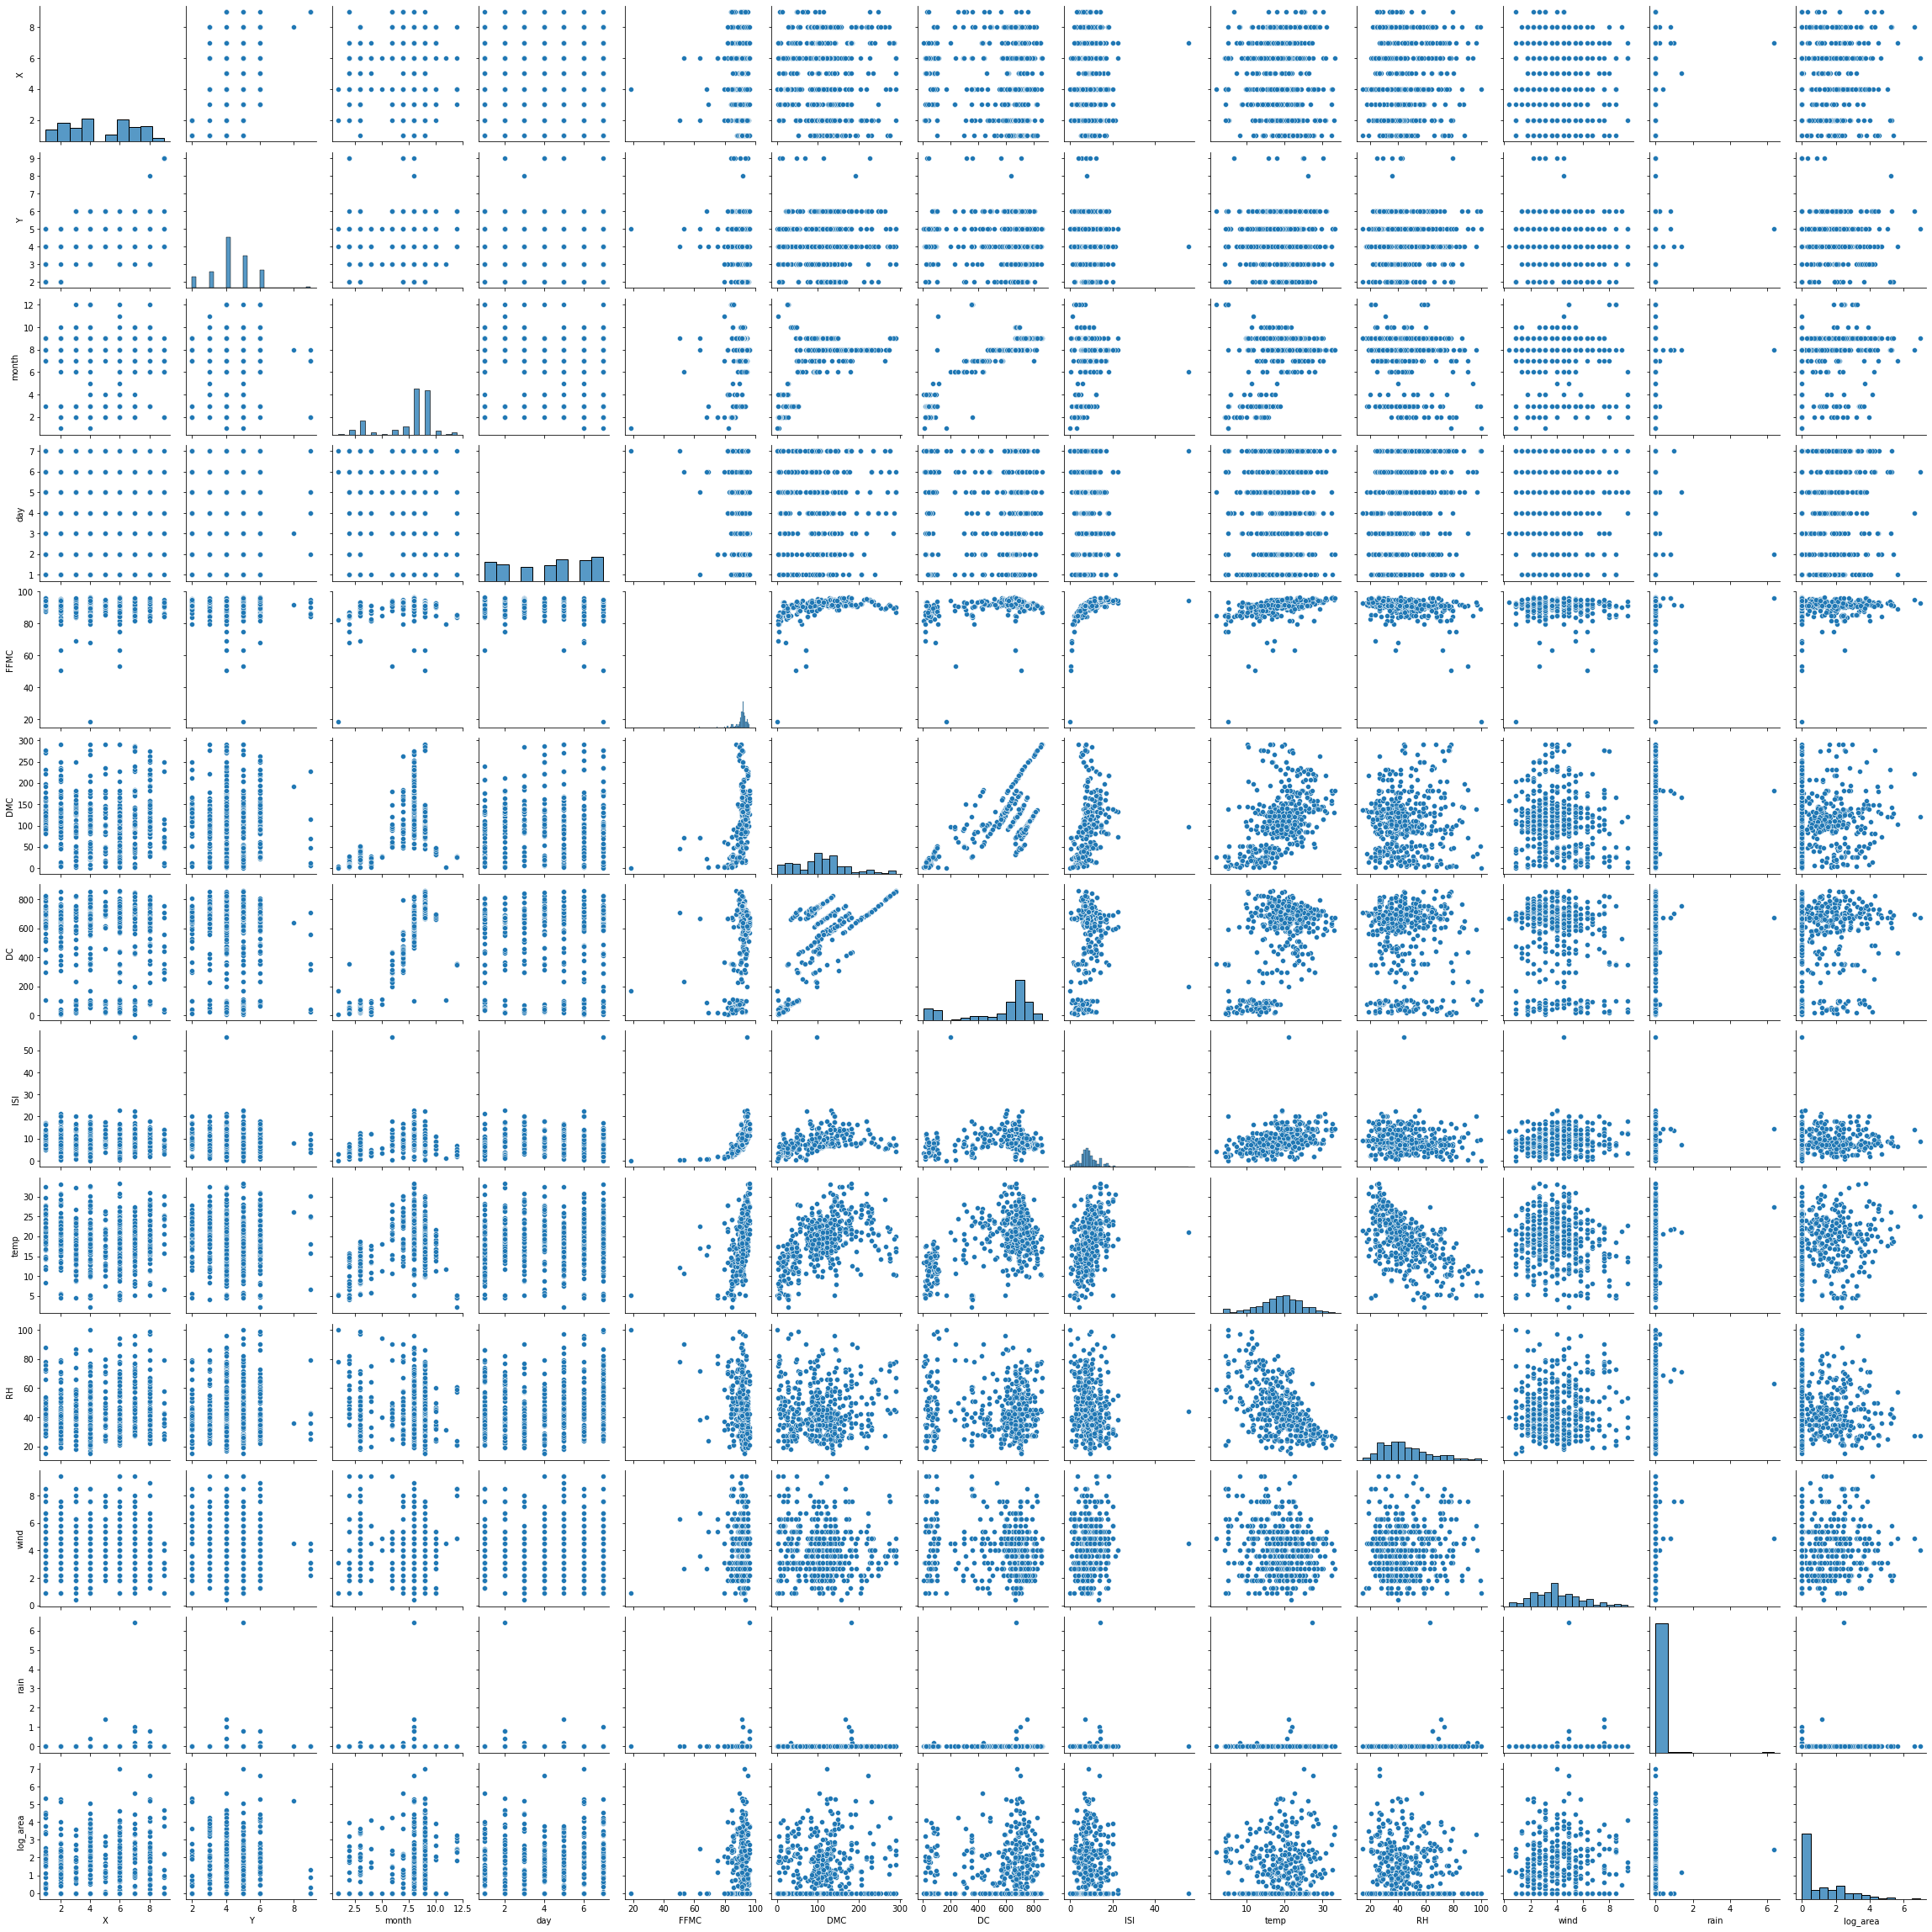

In [16]:
# Plot a pair plot showing each variable vs. every other
# using seaborn pairplot utility
sns.pairplot(DB, height=2.5)

# Linear Regression

#### Separte the predicting attribute into Y for model training

In [17]:
y = DB['log_area'].to_numpy()

DB = DB.drop(['log_area'],axis=1)

X_features = DB.columns
X = DB[X_features].to_numpy()

#### Splitting the data using scikit learn function giving as test size the 30% of all the data

In [18]:
test_size = 0.3
test_seed = 40

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=test_seed)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

X_train.shape  (357, 12)
X_test.shape  (153, 12)


#### The R2 test score given after applying the linear regression model trained on the train data is not satisfactory being much smaller than the train one and even the MSE suggests that with these features I can't predict the area 

In [19]:
model = LinearRegression(fit_intercept=True) 
model = model.fit(X_train, y_train)


y_predict_test = model.predict(X_test)
y_predict_train = model.predict(X_train)


print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))


print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.036682032702140766
Train MSE score  1.8555244360196983
Test R2 score  0.009942320601879162
Test MSE score  2.0208956896937025


In [20]:
for idx, col_name in enumerate(X_features):
    print("The coefficient for {} is {}".format(col_name, model.coef_[idx]))
print("The intercept is {:0.3f}".format(model.intercept_))

The coefficient for X is 0.04347725360028958
The coefficient for Y is 0.03388147225309199
The coefficient for month is 0.10312115752347546
The coefficient for day is 0.035891825189746804
The coefficient for FFMC is 0.013881445186857069
The coefficient for DMC is -0.00012085770495528884
The coefficient for DC is -0.0004701831374852583
The coefficient for ISI is -0.023654626268406146
The coefficient for temp is 0.0011352784391768533
The coefficient for RH is 0.00018294210528415852
The coefficient for wind is 0.07966811139125471
The coefficient for rain is 0.11774454292508382
The intercept is -1.282


# Hypothesis Test

## T-Test

#### I performed a t-test for the coefficent of each of the variables, but in this case will be easy to fall in a type I error for the fact that we are testing many variables independently from one another, also the p-values are not significant

In [21]:
betas = np.array([model.intercept_, *model.coef_]).reshape(-1, 1)
show_stats(X_train, y_train, betas, ['Intercept', * X_features], alpha=0.001)

,Name,Coefficients,Standard Errors,t-stat,p-value,reject H0
0,Intercept,-1.282032,1.523741,-0.841372,0.400723,False
1,X,0.043477,0.037446,1.161065,0.246418,False
2,Y,0.033881,0.072630,0.466493,0.641157,False
3,month,0.103121,0.072900,1.414550,0.158102,False
4,day,0.035892,0.036561,0.981709,0.326931,False
5,FFMC,0.013881,0.015240,0.910854,0.363008,False
6,DMC,-0.000121,0.001953,-0.061894,0.950683,False
7,DC,-0.000470,0.000850,-0.553004,0.580619,False
8,ISI,-0.023655,0.018824,-1.256628,0.209738,False
9,temp,0.001135,0.021546,0.052690,0.958009,False


## F-Test

#### At this point I decided to perform an F-test, which  assumes as H0 that all the features are equal to 0, in my case there is no evidence to say that at least one feature is important. 

In [22]:
betas_complete, y_pred = multiple_least_squares(X_train, y_train)

n = X_train.shape[0]
nf_complete = X_train.shape[1]
# Compute RSS ans TSS
rss_complete = rss(y_train, y_pred)
tss_y = tss(y_train)

# Compute the F statistics
F_num = (tss_y - rss_complete) / nf_complete
F_den = rss_complete / (n - nf_complete - 1)
F = F_num / F_den

# Compute the p-value
alpha = 0.005
p_value = f.sf(F, nf_complete, n - nf_complete - 1)

print("F-stat: ", F)
print("p-value: ", p_value)
if p_value < alpha:
    print("Reject H0: At least one coefficient is different from 0")
else:
    print("Accept H0: No evidence to say that at least one coefficient is different from 0")

F-stat:  1.0915934715488271
p-value:  0.36602935972425626
Accept H0: No evidence to say that at least one coefficient is different from 0


# Polynomial regression

#### I decided to try with polynomial regression after having seen that the linear model of degree 1 doesn't have a good performance on the data. Consequently, to increase the fitness of the linear model I tried to transform my features using higher degrees.

In [23]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly = poly.fit(X_train)

X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

print("X_train_small.shape", X_train.shape, " X_poly_train.shape", X_train_poly.shape)
print("X_train_small.shape", X_test.shape, " X_poly_train.shape", X_test_poly.shape)

X_train_small.shape (357, 12)  X_poly_train.shape (357, 90)
X_train_small.shape (153, 12)  X_poly_train.shape (153, 90)


#### Training and evaluation of the model: R2 score is not good even this time

In [24]:
model = LinearRegression(fit_intercept=True)           
model.fit(X_train_poly, y_train)
y_predict = model.predict(X_test_poly)
print("R2 score ", r2_score(y_test, y_predict))
print("MSE score ", mean_squared_error(y_test, y_predict))

R2 score  -0.30550779995862243
MSE score  2.6647892751074562


#### I used the combined features of the 'GridSearchCV' class from scikit learn to get an exhaustive search over specified parameter values for an estimator.



#### The table below shows the scores of the folds and the best degree parameter which in this case is 1

In [25]:
r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)

model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

In [26]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002637,0.001563,0.000331,0.000057,1,{'poly__degree': 1},-0.064189,-0.107366,-0.027227,-0.307115,-0.037100,-0.108600,0.103069,1
1,0.002620,0.000852,0.000408,0.000094,2,{'poly__degree': 2},-1.190160,-1.415218,-3.600056,-2.144032,-0.660054,-1.801904,1.017643,2
2,0.023649,0.009571,0.000759,0.000422,3,{'poly__degree': 3},-11455.500265,-1121.121139,-1508.884379,-3010.144294,-981.803551,-3615.490725,3985.678661,4
3,0.035869,0.006445,0.000812,0.000067,4,{'poly__degree': 4},-178.819943,-421.378213,-1381.567090,-373.505497,-726.263204,-616.306789,420.965105,3


In [27]:
# Retrieve the best **trained** estimator
cv.best_estimator_
# Retrieve its parameters
cv.best_params_
# Retrieve the best **CV** score
# I.e., mean of the scores on each fold
cv.best_score_

-0.10859950081537809

In [28]:
model = cv.best_estimator_
y_predict = model.predict(X_test)
test_score = r2_score(y_test, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train R2 score:", cv.best_score_)
print("Test R2 score:", test_score)

Best degree: 1
Train R2 score: -0.10859950081537809
Test R2 score: 0.009942320601879162


# Forward feature selection

#### Performing this kind of feature selection (in my case with cross validation inside the function) the machine will be able to add one feature at a time starting from an empty set of features and then give me back the subset of feature that fits better the model (according to this tipe of feature selection). Cross validation gives to the algorithm a more accurate capability to predict the data dividing the training data into different folds using one at a time as validation set

In [29]:
X_train_pd = pd.DataFrame(X_train, columns=X_features)
X_test_pd = pd.DataFrame(X_test, columns=X_features)

............
Best model (M0) with 0 features: ['wind']
M0 subset score (3.): -0.009537345260728136
............
Best model (M1) with 1 features: ['wind', 'month']
M1 subset score (3.): 0.01641433524198177
............
Best model (M2) with 2 features: ['wind', 'month', 'X']
M2 subset score (3.): 0.01777158796081324
............
Best model (M3) with 3 features: ['wind', 'month', 'X', 'ISI']
M3 subset score (3.): 0.017600520611958492
............
Best model (M4) with 4 features: ['wind', 'month', 'X', 'ISI', 'FFMC']
M4 subset score (3.): 0.019112079241312863
............
Best model (M5) with 5 features: ['wind', 'month', 'X', 'ISI', 'FFMC', 'day']
M5 subset score (3.): 0.012770933840066556
............
Best model (M6) with 6 features: ['wind', 'month', 'X', 'ISI', 'FFMC', 'day', 'DC']
M6 subset score (3.): 0.014987025626506889
............
Best model (M7) with 7 features: ['wind', 'month', 'X', 'ISI', 'FFMC', 'day', 'DC', 'rain']
M7 subset score (3.): 0.01323624948736879
............
Best

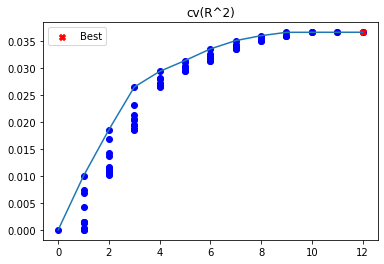

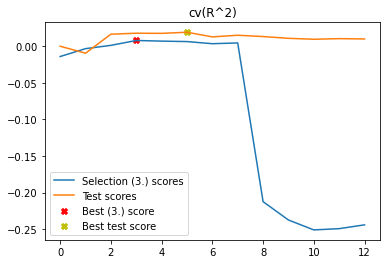

In [30]:
def get_val_evaluator(scorer, val_size=0.3):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=mpg_test_seed)
        
        if not trained:
            model = model.fit(X_train_small, y_train_small)
        score = scorer(model, X_val, y_val) 
        
        return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=3):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator


cv = 10
sigma = estimate_sigma(X_train_pd, y_train)
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  # Use either 5-fold CV or (1-fold cross) validation to 
                  # estimate the test R^2 error at step (3.) of the algorithm
                  get_cv_evaluator(make_scorer(r2_score)), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

#### After retriving this set of features from the FFS, I perform a linear regression to see if this subset will be better in predict the target, but it eventually fails giving back a slightly better but still insignificant R2

In [31]:
X_features = ['wind', 'month', 'X']
X = DB[X_features].to_numpy()
test_seed_v2=40
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y,
                                                                test_size=test_size, 
                                                                random_state=test_seed_v2)

model = LinearRegression()                       
model = model.fit(X_train_small, y_train_small)        
y_predict_test = model.predict(X_test_small)    
y_predict_train = model.predict(X_train_small)


print("Train R2 score ", r2_score(y_train_small, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train_small, y_predict_train))

print("Test R2 score ", r2_score(y_test_small, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test_small, y_predict_test))


Train R2 score  0.02651175027026531
Train MSE score  1.8751142373253888
Test R2 score  0.01777158796081324
Test MSE score  2.004914668599307


In [32]:
r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)

model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])

# Select parameters to optimize
parameters = {'poly__degree': list(range(1,5))}
              #'linear__fit_intercept': [True, False],
              #'linear__normalize': [True, False]}

cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train_small, y_train_small)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

In [33]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001020,0.000303,0.000400,0.000163,1,{'poly__degree': 1},-0.006644,-0.016413,-0.012331,0.069547,-0.005263,0.005779,0.032134,1
1,0.001318,0.000354,0.000283,0.000065,2,{'poly__degree': 2},-0.003669,-0.145713,-0.024245,0.072341,0.027145,-0.014828,0.073081,2
2,0.000554,0.000013,0.000225,0.000002,3,{'poly__degree': 3},-0.008460,-0.334838,-0.104750,0.003402,-0.022769,-0.093483,0.126487,3
3,0.000838,0.000098,0.000268,0.000031,4,{'poly__degree': 4},-0.017915,-1.617994,-0.484092,-0.167581,-0.099926,-0.477502,0.591709,4


In [34]:
# Retrieve the best **trained** estimator
cv.best_estimator_
# Retrieve its parameters
cv.best_params_
# Retrieve the best **CV** score
# I.e., mean of the scores on each fold
cv.best_score_

0.005779313184298518

In [35]:
model = cv.best_estimator_
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train R2 score:", cv.best_score_)
print("Test R2 score:", test_score)

Best degree: 1
Train R2 score: 0.005779313184298518
Test R2 score: 0.01777158796081324


#### I tried again with GridSearchCV but even this time it gives as result that the best degree for the parameters is still 1 and a slightly higher R2 score

# Multicollinearity Detection

#### At this point seeing that with the entire dataset I can't find any good model (and FFS dosn't help so much), I decide to investigate for Multicollinearity inside the complete set of features, because having so many features increase the probability to fall in a multicollinearity issue where some features are predicted by other inside the dataset

In [36]:
X = DB.iloc[:,:]
calc_vif(X)

,variables,VIF
0,X,7.255782
1,Y,18.818672
2,month,59.542802
3,day,5.418690
4,FFMC,74.167678
5,DMC,9.671348
6,DC,46.683593
7,ISI,6.451362
8,temp,29.345050
9,RH,12.736691


#### Dropping variables should be an iterative process starting with the variable having the largest VIF value meaning that the trend of this variable is highly captured by other variables. Doing this I noticed that VIF values for other variables is getting reduced

In [37]:
X = DB.drop(['FFMC'],axis=1)
calc_vif(X)

,variables,VIF
0,X,7.253938
1,Y,17.590067
2,month,51.511796
3,day,5.360234
4,DMC,9.637725
5,DC,44.082362
6,ISI,6.278022
7,temp,18.052048
8,RH,8.878320
9,wind,6.398689


In [38]:
X = DB.drop(['X','Y','FFMC','month'],axis=1)
calc_vif(X)

,variables,VIF
0,day,5.345844
1,DMC,8.126130
2,DC,12.115242
3,ISI,6.248502
4,temp,13.733413
5,RH,6.589878
6,wind,5.412917
7,rain,1.026488


#### The VIF scores in fact is getting smaller for many feature just by eliminating the ones that have a very high score. I decided to keep temperature because even if it has a score higher than the other it still remains in the cutoff of 20 

#### In this case I also decided to do feature engeneering eliminating the 'X' and 'Y' features beacuse I wasn't able to give them any explanation for the result I was looking for, being, those features, simple numbers (assuming having no correlation with the other features) which may interfer with the model evaluation

In [39]:
#separate the other attributes from the predicting attribute
DB = DB.drop(['X','Y','FFMC','month'],axis=1)
X_features = DB.columns
X = DB[X_features].to_numpy()

In [40]:
# perform linear regression in the restricted set of features
test_seed_v2=40
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X, y,
                                                                test_size=test_size, 
                                                                random_state=test_seed_v2)

model = LinearRegression()                       
model = model.fit(X_train_small, y_train_small)        
y_predict_test = model.predict(X_test_small)    
y_predict_train = model.predict(X_train_small)


print("Train R2 score ", r2_score(y_train_small, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train_small, y_predict_train))

print("Test R2 score ", r2_score(y_test_small, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test_small, y_predict_test))


Train R2 score  0.019399422911339892
Train MSE score  1.8888138647168262
Test R2 score  -0.007182057789183016
Test MSE score  2.055849797115221


#### Even with this method I get a worst R2

# Conclusion

#### Even with multicollinearity tests I'm not able to fit properly with any linear regression model the features of the dataset to predict the area, this, according to literature, may be given by the fact that the target feature - area - presents many zeros making difficoult for a linear model to fit properly this data. In fact many papers suggest tu use other models, such as decision tree and support vector machine, for regression.